In [1]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
import random
import math
import os

from __future__ import division, print_function, absolute_import

import tensorflow as tf
import tflearn
from tflearn.data_utils import shuffle, to_categorical
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.conv import conv_2d, max_pool_2d, avg_pool_2d
from tflearn.layers.normalization import local_response_normalization
from tflearn.layers.merge_ops import merge
from tflearn.layers.estimator import regression

%matplotlib inline 

import matplotlib.gridspec as gridspec
from utils import *
%load_ext autoreload
%autoreload 2

Using TensorFlow backend.


In [ ]:
train_path = "../datasets/scaled_train_batch"
test_path = "../datasets/scaled_test_batch"
X_train, y_train, X_val, y_val, X_test, X_test_name = load_data(train_path, test_path, 1, train_crop = False, test_crop = False)

In [2]:
# with open("../datasets/sample_train_batch", "rb") as f:
# with open("../datasets/train_batch", "rb") as f:
random.seed(1)
with open("../datasets/scaled_train_batch", "rb") as f:
    data_dict = pickle.load(f)
#     X = data_dict['data'].transpose([0, 3, 1, 2])
    X = data_dict['data'].astype('float32')
    Y = data_dict['label']
    print((X.shape, Y.shape))

Y = Y - 1
X, Y = shuffle(X, Y)
Y = to_categorical(Y, 3)   

N_train = math.floor(X.shape[0] * 0.9)
N_val = X.shape[0] - N_train
ix = [i for i in range(X.shape[0])]
random.shuffle(ix)

train_ix = ix[:N_train]
val_ix = ix[N_train:]
# print(val_ix)

X_train = X[train_ix]
y_train = Y[train_ix]
X_val = X[val_ix]
y_val = Y[val_ix]

((1480, 256, 256, 3), (1480,))


In [8]:
tf.reset_default_graph()
img_prep = tflearn.ImagePreprocessing()
img_prep.add_featurewise_zero_center(per_channel=True, mean = [-36.65057373, 4.90035343, -15.91570091])


# Real-time data augmentation
img_aug = tflearn.ImageAugmentation()
img_aug.add_random_flip_leftright()
img_aug.add_random_rotation(max_angle=45.0)

# network = input_data(shape=[None, 256, 256, 3])
model_input = tflearn.input_data(shape=[None, 256, 256, 3],
                         data_preprocessing=img_prep,
                         data_augmentation=img_aug)
conv1_7_7 = conv_2d(model_input, 64, 7, strides=2, activation='relu', name = 'conv1_7_7_s2')
pool1_3_3 = max_pool_2d(conv1_7_7, 3,strides=2)
pool1_3_3 = local_response_normalization(pool1_3_3)
conv2_3_3_reduce = conv_2d(pool1_3_3, 64,1, activation='relu',name = 'conv2_3_3_reduce')
conv2_3_3 = conv_2d(conv2_3_3_reduce, 192,3, activation='relu', name='conv2_3_3')
conv2_3_3 = local_response_normalization(conv2_3_3)
pool2_3_3 = max_pool_2d(conv2_3_3, kernel_size=3, strides=2, name='pool2_3_3_s2')
inception_3a_1_1 = conv_2d(pool2_3_3, 64, 1, activation='relu', name='inception_3a_1_1')
inception_3a_3_3_reduce = conv_2d(pool2_3_3, 96,1, activation='relu', name='inception_3a_3_3_reduce')
inception_3a_3_3 = conv_2d(inception_3a_3_3_reduce, 128,filter_size=3,  activation='relu', name = 'inception_3a_3_3')
inception_3a_5_5_reduce = conv_2d(pool2_3_3,16, filter_size=1,activation='relu', name ='inception_3a_5_5_reduce' )
inception_3a_5_5 = conv_2d(inception_3a_5_5_reduce, 32, filter_size=5, activation='relu', name= 'inception_3a_5_5')
inception_3a_pool = max_pool_2d(pool2_3_3, kernel_size=3, strides=1, )
inception_3a_pool_1_1 = conv_2d(inception_3a_pool, 32, filter_size=1, activation='relu', name='inception_3a_pool_1_1')

# merge the inception_3a__
inception_3a_output = merge([inception_3a_1_1, inception_3a_3_3, inception_3a_5_5, inception_3a_pool_1_1], mode='concat', axis=3)

inception_3b_1_1 = conv_2d(inception_3a_output, 128,filter_size=1,activation='relu', name= 'inception_3b_1_1' )
inception_3b_3_3_reduce = conv_2d(inception_3a_output, 128, filter_size=1, activation='relu', name='inception_3b_3_3_reduce')
inception_3b_3_3 = conv_2d(inception_3b_3_3_reduce, 192, filter_size=3,  activation='relu',name='inception_3b_3_3')
inception_3b_5_5_reduce = conv_2d(inception_3a_output, 32, filter_size=1, activation='relu', name = 'inception_3b_5_5_reduce')
inception_3b_5_5 = conv_2d(inception_3b_5_5_reduce, 96, filter_size=5,  name = 'inception_3b_5_5')
inception_3b_pool = max_pool_2d(inception_3a_output, kernel_size=3, strides=1,  name='inception_3b_pool')
inception_3b_pool_1_1 = conv_2d(inception_3b_pool, 64, filter_size=1,activation='relu', name='inception_3b_pool_1_1')

#merge the inception_3b_*
inception_3b_output = merge([inception_3b_1_1, inception_3b_3_3, inception_3b_5_5, inception_3b_pool_1_1], mode='concat',axis=3,name='inception_3b_output')

pool3_3_3 = max_pool_2d(inception_3b_output, kernel_size=3, strides=2, name='pool3_3_3')
inception_4a_1_1 = conv_2d(pool3_3_3, 192, filter_size=1, activation='relu', name='inception_4a_1_1')
inception_4a_3_3_reduce = conv_2d(pool3_3_3, 96, filter_size=1, activation='relu', name='inception_4a_3_3_reduce')
inception_4a_3_3 = conv_2d(inception_4a_3_3_reduce, 208, filter_size=3,  activation='relu', name='inception_4a_3_3')
inception_4a_5_5_reduce = conv_2d(pool3_3_3, 16, filter_size=1, activation='relu', name='inception_4a_5_5_reduce')
inception_4a_5_5 = conv_2d(inception_4a_5_5_reduce, 48, filter_size=5,  activation='relu', name='inception_4a_5_5')
inception_4a_pool = max_pool_2d(pool3_3_3, kernel_size=3, strides=1,  name='inception_4a_pool')
inception_4a_pool_1_1 = conv_2d(inception_4a_pool, 64, filter_size=1, activation='relu', name='inception_4a_pool_1_1')

inception_4a_output = merge([inception_4a_1_1, inception_4a_3_3, inception_4a_5_5, inception_4a_pool_1_1], mode='concat', axis=3, name='inception_4a_output')


inception_4b_1_1 = conv_2d(inception_4a_output, 160, filter_size=1, activation='relu', name='inception_4a_1_1')
inception_4b_3_3_reduce = conv_2d(inception_4a_output, 112, filter_size=1, activation='relu', name='inception_4b_3_3_reduce')
inception_4b_3_3 = conv_2d(inception_4b_3_3_reduce, 224, filter_size=3, activation='relu', name='inception_4b_3_3')
inception_4b_5_5_reduce = conv_2d(inception_4a_output, 24, filter_size=1, activation='relu', name='inception_4b_5_5_reduce')
inception_4b_5_5 = conv_2d(inception_4b_5_5_reduce, 64, filter_size=5,  activation='relu', name='inception_4b_5_5')

inception_4b_pool = max_pool_2d(inception_4a_output, kernel_size=3, strides=1,  name='inception_4b_pool')
inception_4b_pool_1_1 = conv_2d(inception_4b_pool, 64, filter_size=1, activation='relu', name='inception_4b_pool_1_1')

inception_4b_output = merge([inception_4b_1_1, inception_4b_3_3, inception_4b_5_5, inception_4b_pool_1_1], mode='concat', axis=3, name='inception_4b_output')


inception_4c_1_1 = conv_2d(inception_4b_output, 128, filter_size=1, activation='relu',name='inception_4c_1_1')
inception_4c_3_3_reduce = conv_2d(inception_4b_output, 128, filter_size=1, activation='relu', name='inception_4c_3_3_reduce')
inception_4c_3_3 = conv_2d(inception_4c_3_3_reduce, 256,  filter_size=3, activation='relu', name='inception_4c_3_3')
inception_4c_5_5_reduce = conv_2d(inception_4b_output, 24, filter_size=1, activation='relu', name='inception_4c_5_5_reduce')
inception_4c_5_5 = conv_2d(inception_4c_5_5_reduce, 64,  filter_size=5, activation='relu', name='inception_4c_5_5')

inception_4c_pool = max_pool_2d(inception_4b_output, kernel_size=3, strides=1)
inception_4c_pool_1_1 = conv_2d(inception_4c_pool, 64, filter_size=1, activation='relu', name='inception_4c_pool_1_1')

inception_4c_output = merge([inception_4c_1_1, inception_4c_3_3, inception_4c_5_5, inception_4c_pool_1_1], mode='concat', axis=3,name='inception_4c_output')

inception_4d_1_1 = conv_2d(inception_4c_output, 112, filter_size=1, activation='relu', name='inception_4d_1_1')
inception_4d_3_3_reduce = conv_2d(inception_4c_output, 144, filter_size=1, activation='relu', name='inception_4d_3_3_reduce')
inception_4d_3_3 = conv_2d(inception_4d_3_3_reduce, 288, filter_size=3, activation='relu', name='inception_4d_3_3')
inception_4d_5_5_reduce = conv_2d(inception_4c_output, 32, filter_size=1, activation='relu', name='inception_4d_5_5_reduce')
inception_4d_5_5 = conv_2d(inception_4d_5_5_reduce, 64, filter_size=5,  activation='relu', name='inception_4d_5_5')
inception_4d_pool = max_pool_2d(inception_4c_output, kernel_size=3, strides=1,  name='inception_4d_pool')
inception_4d_pool_1_1 = conv_2d(inception_4d_pool, 64, filter_size=1, activation='relu', name='inception_4d_pool_1_1')

inception_4d_output = merge([inception_4d_1_1, inception_4d_3_3, inception_4d_5_5, inception_4d_pool_1_1], mode='concat', axis=3, name='inception_4d_output')

inception_4e_1_1 = conv_2d(inception_4d_output, 256, filter_size=1, activation='relu', name='inception_4e_1_1')
inception_4e_3_3_reduce = conv_2d(inception_4d_output, 160, filter_size=1, activation='relu', name='inception_4e_3_3_reduce')
inception_4e_3_3 = conv_2d(inception_4e_3_3_reduce, 320, filter_size=3, activation='relu', name='inception_4e_3_3')
inception_4e_5_5_reduce = conv_2d(inception_4d_output, 32, filter_size=1, activation='relu', name='inception_4e_5_5_reduce')
inception_4e_5_5 = conv_2d(inception_4e_5_5_reduce, 128,  filter_size=5, activation='relu', name='inception_4e_5_5')
inception_4e_pool = max_pool_2d(inception_4d_output, kernel_size=3, strides=1,  name='inception_4e_pool')
inception_4e_pool_1_1 = conv_2d(inception_4e_pool, 128, filter_size=1, activation='relu', name='inception_4e_pool_1_1')


inception_4e_output = merge([inception_4e_1_1, inception_4e_3_3, inception_4e_5_5,inception_4e_pool_1_1],axis=3, mode='concat')

pool4_3_3 = max_pool_2d(inception_4e_output, kernel_size=3, strides=2, name='pool_3_3')


inception_5a_1_1 = conv_2d(pool4_3_3, 256, filter_size=1, activation='relu', name='inception_5a_1_1')
inception_5a_3_3_reduce = conv_2d(pool4_3_3, 160, filter_size=1, activation='relu', name='inception_5a_3_3_reduce')
inception_5a_3_3 = conv_2d(inception_5a_3_3_reduce, 320, filter_size=3, activation='relu', name='inception_5a_3_3')
inception_5a_5_5_reduce = conv_2d(pool4_3_3, 32, filter_size=1, activation='relu', name='inception_5a_5_5_reduce')
inception_5a_5_5 = conv_2d(inception_5a_5_5_reduce, 128, filter_size=5,  activation='relu', name='inception_5a_5_5')
inception_5a_pool = max_pool_2d(pool4_3_3, kernel_size=3, strides=1,  name='inception_5a_pool')
inception_5a_pool_1_1 = conv_2d(inception_5a_pool, 128, filter_size=1,activation='relu', name='inception_5a_pool_1_1')

inception_5a_output = merge([inception_5a_1_1, inception_5a_3_3, inception_5a_5_5, inception_5a_pool_1_1], axis=3,mode='concat')


inception_5b_1_1 = conv_2d(inception_5a_output, 384, filter_size=1,activation='relu', name='inception_5b_1_1')
inception_5b_3_3_reduce = conv_2d(inception_5a_output, 192, filter_size=1, activation='relu', name='inception_5b_3_3_reduce')
inception_5b_3_3 = conv_2d(inception_5b_3_3_reduce, 384,  filter_size=3,activation='relu', name='inception_5b_3_3')
inception_5b_5_5_reduce = conv_2d(inception_5a_output, 48, filter_size=1, activation='relu', name='inception_5b_5_5_reduce')
inception_5b_5_5 = conv_2d(inception_5b_5_5_reduce,128, filter_size=5,  activation='relu', name='inception_5b_5_5' )
inception_5b_pool = max_pool_2d(inception_5a_output, kernel_size=3, strides=1,  name='inception_5b_pool')
inception_5b_pool_1_1 = conv_2d(inception_5b_pool, 128, filter_size=1, activation='relu', name='inception_5b_pool_1_1')
inception_5b_output = merge([inception_5b_1_1, inception_5b_3_3, inception_5b_5_5, inception_5b_pool_1_1], axis=3, mode='concat')

pool5_7_7 = avg_pool_2d(inception_5b_output, kernel_size=7, strides=1)
pool5_7_7 = dropout(pool5_7_7, 0.4)
loss = fully_connected(pool5_7_7, 3, activation='softmax')
network = regression(loss, optimizer='momentum',
                     loss='categorical_crossentropy',
                     learning_rate = 0.001)
#                      learning_rate=0.001)
model = tflearn.DNN(network, best_checkpoint_path='best_model_googlenet_scaled',
                    max_checkpoints=1, tensorboard_verbose=2)


In [7]:
model.fit(X_train, y_train, n_epoch=10, validation_set=(X_val, y_val), shuffle=True,
          show_metric=True, batch_size=64, snapshot_step=500, snapshot_epoch = True, run_id='googlenet_scale')

Training Step: 209  | total loss: 0.92620 | time: 30.914s
| Momentum | epoch: 010 | loss: 0.92620 - acc: 0.5776 -- iter: 1280/1332
Training Step: 210  | total loss: 0.93142 | time: 33.682s
| Momentum | epoch: 010 | loss: 0.93142 - acc: 0.5761 | val_loss: 0.85986 - val_acc: 0.6216 -- iter: 1332/1332
--


In [8]:
model.fit(X_train, y_train, n_epoch=20, validation_set=(X_val, y_val), shuffle=True,
          show_metric=True, batch_size=64, snapshot_step=500, snapshot_epoch = True, run_id='googlenet_scale')

Training Step: 629  | total loss: 0.76359 | time: 30.962s
| Momentum | epoch: 030 | loss: 0.76359 - acc: 0.6631 -- iter: 1280/1332
Training Step: 630  | total loss: 0.76232 | time: 33.736s
| Momentum | epoch: 030 | loss: 0.76232 - acc: 0.6609 | val_loss: 0.75906 - val_acc: 0.6757 -- iter: 1332/1332
--


In [13]:
model.fit(X_train, y_train, n_epoch=20, validation_set=(X_val, y_val), shuffle=True,
          show_metric=True, batch_size=64, snapshot_step=500, snapshot_epoch = True, run_id='googlenet_scale')

Training Step: 2729  | total loss: 0.42177 | time: 31.009s
| Momentum | epoch: 130 | loss: 0.42177 - acc: 0.8242 -- iter: 1280/1332
Training Step: 2730  | total loss: 0.42087 | time: 33.799s
| Momentum | epoch: 130 | loss: 0.42087 - acc: 0.8246 | val_loss: 0.73621 - val_acc: 0.6757 -- iter: 1332/1332
--


In [19]:
model.fit(X_train, y_train, n_epoch=1, validation_set=(X_val, y_val), shuffle=True,
          show_metric=True, batch_size=64, snapshot_step=500, snapshot_epoch = True, run_id='googlenet_scale1')

Training Step: 2771  | total loss: 0.66635 | time: 36.084s
| Momentum | epoch: 001 | loss: 0.66635 - acc: 0.7176 -- iter: 1280/1332
Training Step: 2772  | total loss: 0.66279 | time: 40.784s
| Momentum | epoch: 001 | loss: 0.66279 - acc: 0.7209 | val_loss: 0.66621 - val_acc: 0.7297 -- iter: 1332/1332
--


In [49]:
with open("../datasets/scaled_test_batch", "rb") as f:
    data_dict = pickle.load(f)
    X_test = data_dict['data'].astype('float32')
    X_test_name = data_dict['image_name']
    
y_test_pred = model.predict(X_test)
with open('../results/googlenet2.csv','w') as f:
    f.write("image_name,Type_1,Type_2,Type_3\n")
    for i in range(len(y_test_pred)):
        f.write("%s,%f,%f,%f\n" % (X_test_name[i], y_test_pred[i][0], y_test_pred[i][1], y_test_pred[i][2]))

In [9]:
# model.save('googlenet_1')
# model.load('resnet')
model.load('best_model_googlenet_scaled7095')

In [51]:
batch_size = 64
X_train_pred = list()
for i in range(X_train.shape[0]//batch_size + 1):
    if ((i+1) * batch_size) < X_train.shape[0]:
        ix = range(i * batch_size, (i+1) * batch_size)
    else:
        ix = range(i * batch_size, X_train.shape[0])
    pred = model.predict(X_train[ix])
    X_train_pred = X_train_pred + pred

In [130]:
print(len(X_train_pred))

1332


In [52]:
X_val_pred = model.predict(X_val)

In [ ]:
# count the parameters size
parameter_size = 0
for v in tf.trainable_variables():
    s = v.get_shape().as_list()
    #print((s, np.prod(s)))
    parameter_size += np.prod(s)
    #print(s)
print(parameter_size/1.0e6)

In [13]:
def change_channel(image, new_channel = [2,1,0]):
    image = image.astype(np.uint8)
    new_image = np.zeros_like(image)
    for i in range(len(new_channel)):
        new_image[:,:,i] = image[:,:,new_channel[i]]
    return new_image    

%matplotlib inline 
# plt.imshow(change_channel(X[2,:,:,:], [0, 1, 2]))
# plt.show()

In [14]:
from vis_utils import visualize_grid
plt.switch_backend("agg")

def plot_weight(weight, name, output_path = "../results/visualization"):
    os.makedirs(output_path, exist_ok=True)
    w = np.transpose(weight, axes=[3, 0, 1, 2])
    grid = visualize_grid(w)
    plt.imshow(grid.astype(np.uint8))
    plt.gcf().set_size_inches(6, 8)
    plt.axis('off')
    file_name = name.replace("/", "_")
    plt.savefig("{}.png".format(os.path.join(output_path, file_name)), format='png')

(7, 7, 3, 64)


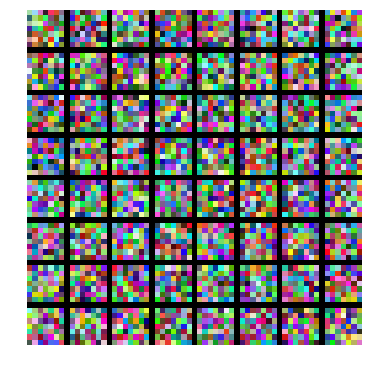

In [15]:
#model.load()
for var in tf.trainable_variables():
    if var.name.startswith('conv1_7_7_s2') and len(var.get_shape().as_list()) == 4:
        print(var.get_shape())
        w = model.session.run(var)
        plot_weight(w, var.name)

In [16]:
def compare_labels(pred_prob, label, num_classes = 3):
    pred_prob = np.array(pred_prob)
    pred_label = np.argmax(pred_prob, axis = 1)
    label = label.dot(np.array([0, 1, 2]))
#     print(pred_label.shape, label.shape)
    # prediction matrix
    pred_summary = np.zeros((num_classes, num_classes))
#     N = pred_prob.shape[0]
    for i in range(num_classes):
        for j in range(num_classes):
#             print(np.sum((label == i) * (pred_label == j)).shape)
            pred_summary[i,j] = np.sum((label == i) * (pred_label == j))
    pred_summary_total = np.sum(pred_summary, axis = 1)
    pred_summary_prob = np.zeros_like(pred_summary)
    for i in range(num_classes):
        pred_summary_prob[i,:] = pred_summary[i,:] * 1.0/pred_summary_total[i]
#     pred_summary_prob = pred_summary/np.reshape(pred_summary_total,(1,num_classes))
        
    return (pred_summary, pred_summary_total, pred_summary_prob)       

In [34]:
print(type(X_train_pred), type(y_train))

<class 'list'> <class 'numpy.ndarray'>


In [53]:
X_train_pred_summary, X_train_pred_total, X_train_pred_prob = compare_labels(X_train_pred, y_train)
print(X_train_pred_summary)
print(X_train_pred_total)
print(X_train_pred_prob)

[[ 125.   89.   13.]
 [  62.  605.   35.]
 [  19.   68.  316.]]
[ 227.  702.  403.]
[[ 0.55066079  0.39207048  0.05726872]
 [ 0.08831909  0.86182336  0.04985755]
 [ 0.0471464   0.16873449  0.78411911]]


In [54]:
X_val_pred_summary, X_val_pred_total, X_val_pred_prob = compare_labels(X_val_pred, y_val)
print(X_val_pred_summary)
print(X_val_pred_total)
print(X_val_pred_prob)

[[ 12.  10.   1.]
 [  7.  71.   1.]
 [  6.  26.  14.]]
[ 23.  79.  46.]
[[ 0.52173913  0.43478261  0.04347826]
 [ 0.08860759  0.89873418  0.01265823]
 [ 0.13043478  0.56521739  0.30434783]]


In [ ]:
print(type(X_train_pred_summary))

In [24]:
def select_images(images, pred_prob, label, select_label, num_best_images = 5, num_worst_images = 5):
    label = label.dot(np.array([0, 1, 2]))
    pred_prob = np.array(pred_prob)
#     correct_prob = pred_prob[:,label]
    correct_prob = pred_prob[range(pred_prob.shape[0]),list(label.astype(int))]
#     sort_prob_ix = np.argsort(correct_prob)
    select_prob = correct_prob[label == select_label]
    select_images = images[label == select_label]
    select_sort_prob_ix = np.argsort(select_prob)
    best_images = np.zeros((num_best_images, images.shape[1], images.shape[2],images.shape[3]))
    worst_images = np.zeros((num_worst_images, images.shape[1], images.shape[2],images.shape[3]))
    best_probs = np.zeros((num_best_images,))
    worst_probs = np.zeros((num_worst_images,))
    for i in range(num_best_images):
#         best_images[i] = select_images[select_sort_prob_ix[-i]]
        best_images[i] = select_images[select_sort_prob_ix[-i-1]]
        best_probs[i] = np.round(select_prob[select_sort_prob_ix[-i-1]],3)
        
    for i in range(num_worst_images):
        worst_images[i] = select_images[select_sort_prob_ix[i]]
        worst_probs[i] = np.round(select_prob[select_sort_prob_ix[i]],3)
    
    
    return (best_images, worst_images, best_probs, worst_probs)

In [25]:
type1_best_images, type1_worst_images, type1_best_probs, type1_worst_probs = select_images(X_train, X_train_pred, y_train, 0)
type2_best_images, type2_worst_images, type2_best_probs, type2_worst_probs = select_images(X_train, X_train_pred, y_train, 1)
type3_best_images, type3_worst_images, type3_best_probs, type3_worst_probs = select_images(X_train, X_train_pred, y_train, 2)

In [84]:
type1_best_images, type1_worst_images, type1_best_probs, type1_worst_probs = select_images(X_val, X_val_pred, y_val, 0)
type2_best_images, type2_worst_images, type2_best_probs, type2_worst_probs = select_images(X_val, X_val_pred, y_val, 1)
type3_best_images, type3_worst_images, type3_best_probs, type3_worst_probs = select_images(X_val, X_val_pred, y_val, 2)

In [37]:
def change_channel(img, new_channel = [2,1,0], normalize = False):
    image = img.astype('uint8')
    if normalize:
        img_max, img_min = np.max(img), np.min(img)
        img = 255.0 * (img - img_min) / (img_max - img_min)
#     image = img.astype('uint8')
    new_image = np.zeros_like(image)
    for i in range(len(new_channel)):
        new_image[:,:,i] = image[:,:,new_channel[i]]
    return new_image    

In [27]:
def plot_results(total_rows, row_id, best_images, worst_images, best_probs, worst_probs, file_name = None, num_images = 5, 
                 output_path = "../results/visualization", save_fig = False, show_fig = False):
    total_images = 2 * num_images
    plt.figure(figsize=(20,30))
    for i in range(num_images):
        plt.subplot(total_rows, total_images, total_images * row_id + 1 + i)
        plt.imshow(change_channel(best_images[i], [0, 1, 2]))
        plt.gca().axis('off')
        plt.title(str(best_probs[i]), fontsize = 18, y=-0.3)
        
    for i in range(num_images):
        plt.subplot(total_rows, total_images, total_images * row_id + 1 + num_images + i)
        plt.imshow(change_channel(worst_images[num_images - 1- i], [0, 1, 2]))
        plt.gca().axis('off')
        plt.title(str(worst_probs[num_images - 1- i]), fontsize = 18, y=-0.3)
    
#     plt.tight_layout()
#     plt.subplots_adjust(hspace=-0.3)
#     if show_fig:
#         plt.show()
    if save_fig:    
        plt.savefig("{}.png".format(os.path.join(output_path, file_name)), format='png', bbox_inches='tight')

In [56]:
def plot_all_results(best_images_list, worst_images_list, best_probs_list, worst_probs_list, file_name = None, 
                     num_images = 5, output_path = "../results/visualization", save_fig = False, show_fig = False):
    total_rows = len(best_images_list)
    for i in range(total_rows):
        plot_results(total_rows, i, best_images_list[i], worst_images_list[i], best_probs_list[i], worst_probs_list[i])
#     plt.show()    

In [28]:
best_images_list = [type1_best_images, type2_best_images, type3_best_images]
worst_images_list = [type1_worst_images, type2_worst_images, type3_worst_images]
best_probs_list = [type1_best_probs, type2_best_probs, type3_best_probs]
worst_probs_list = [type1_worst_probs, type2_worst_probs, type3_worst_probs]

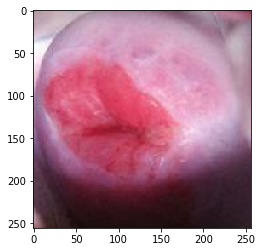

In [34]:
# plt.imshow(change_channel(X_train[3].astype('uint8'), new_channel = [0,1,2], normalize = True))
plt.imshow(change_channel(X_train[3], new_channel = [0,1,2], normalize = False))
# plt.imshow(change_channel(X_test[0], new_channel = [2,0,1], normalize = False))

# plt.imshow(X_test[0].astype('uint8'))
plt.show()

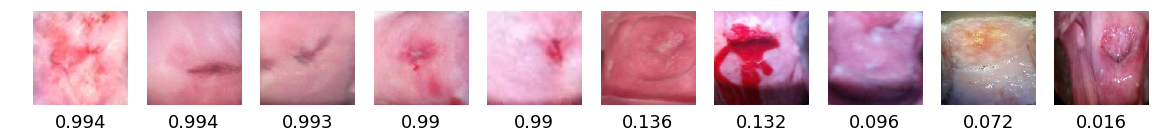

In [38]:
plot_results(1, 0, type2_best_images, type2_worst_images, type2_best_probs, type2_worst_probs, "type2_pred_images", 
             save_fig = True)

In [ ]:
plot_results(1, 0, type3_best_images, type3_worst_images, type3_best_probs, type3_worst_probs, "type3_pred_images", 
             save_fig = True)

In [ ]:
plot_results(1, 0, type1_best_images, type1_worst_images, type1_best_probs, type1_worst_probs, "type1_pred_images", 
             save_fig = True)

In [ ]:
plot_all_results(best_images_list, worst_images_list, best_probs_list, worst_probs_list)
output_path = "../results/visualization"
file_name = "googlenet_result"
plt.savefig("{}.png".format(os.path.join(output_path, file_name)), format='png')

In [ ]:
# num_classes = 3
image = tf.placeholder(tf.float32, [None, 256, 256, 3])
# label = tf.placeholder(tf.int32, [None, num_classes])
label = tf.placeholder(tf.int32, [None,])
# scores = loss


In [36]:
def compute_saliency_maps(X, y, model, model_path):
    """
    Compute a class saliency map using the model for images X and labels y.

    Input:
    - X: Input images, numpy array of shape (N, H, W, 3)
    - y: Labels for X, numpy of shape (N,)
    - model: A SqueezeNet model that will be used to compute the saliency map.

    Returns:
    - saliency: A numpy array of shape (N, H, W) giving the saliency maps for the
    input images.
    """
    saliency = None
    # Compute the score of the correct class for each example.
    # This gives a Tensor with shape [N], the number of examples.
    #
    # Note: this is equivalent to scores[np.arange(N), y] we used in NumPy
    # for computing vectorized losses.
    correct_scores = tf.gather_nd(loss,
                                  tf.stack((tf.range(X.shape[0]), y), axis=1))
    grads = tf.squeeze(tf.gradients(correct_scores, model_input))
#     grads = tf.gradients(correct_scores, model_input)
#     sal = tf.reduce_max(tf.abs(grads), axis = 3)
    sal = tf.reduce_max(tf.abs(grads), axis = 3)
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        model.load(model_path)
        saliency = sess.run(sal, feed_dict = {model_input: X})

    return saliency

In [ ]:
def show_saliency_maps(X, y, mask):
    mask = np.asarray(mask)
    Xm = X[mask]
    ym = y[mask]

    saliency = compute_saliency_maps(Xm, ym, model)
#     print(saliency[1].shape)

    for i in range(mask.size):
        plt.subplot(2, mask.size, i + 1)
#         plt.imshow(deprocess_image(Xm[i]))
        plt.imshow(change_channel(Xm[i], [0, 1, 2]))
        plt.axis('off')
#         plt.title(class_names[ym[i]])
        plt.subplot(2, mask.size, mask.size + i + 1)
        plt.title(mask[i])
        plt.imshow(saliency[i], cmap=plt.cm.hot)
        plt.axis('off')
        plt.gcf().set_size_inches(10, 4)
    plt.show()
    
# print(X.shape)    


In [ ]:
from image_utils import preprocess_image, deprocess_image

In [42]:
def show_saliency_maps(X, y, mask, prob, model_path, output_path = None):
    mask = np.asarray(mask)
    Xm = X[mask]
    ym = y[mask]

    saliency = compute_saliency_maps(Xm, ym, model, model_path)
#     print(saliency[1].shape)
    plt.figure(figsize=(8,4))
#     plt.figure(figsize=(8,3))
    for i in range(mask.size):
        plt.subplot(2, mask.size, i + 1)
#         plt.imshow(deprocess_image(Xm[i]))
        plt.imshow(change_channel(Xm[i], [0, 1, 2]))
        plt.axis('off')
#         plt.title(class_names[ym[i]])
        plt.subplot(2, mask.size, mask.size + i + 1)
#         plt.title(mask[i])
        plt.title(prob[i], fontsize = 13)
        plt.imshow(saliency[i], cmap=plt.cm.hot)
        plt.axis('off')
#         plt.gcf().set_size_inches(10, 4)
    plt.subplots_adjust(hspace=-0.6)
#     plt.show()
    if output_path is not None:
        plt.savefig(output_path, bbox_inches='tight', transparent = True)

In [40]:
num_images = 5
type1_images = np.concatenate((type1_best_images[range(0,num_images)], type1_worst_images[range(num_images-1,-1,-1)]))
type1_probs = np.concatenate((type1_best_probs[range(0,num_images)], type1_worst_probs[range(num_images-1,-1,-1)]))
type2_images = np.concatenate((type2_best_images[range(0,num_images)], type2_worst_images[range(num_images-1,-1,-1)]))
type2_probs = np.concatenate((type2_best_probs[range(0,num_images)], type2_worst_probs[range(num_images-1,-1,-1)]))
type3_images = np.concatenate((type3_best_images[range(0,num_images)], type3_worst_images[range(num_images-1,-1,-1)]))
type3_probs = np.concatenate((type3_best_probs[range(0,num_images)], type3_worst_probs[range(num_images-1,-1,-1)]))

In [41]:
type1_labels = np.zeros((2 * num_images,)).astype(int)
type2_labels = np.ones((2 * num_images,)).astype(int)
type3_labels = 2 * np.ones((2 * num_images,)).astype(int)

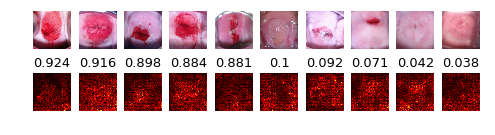

In [44]:
mask = np.arange(2 * num_images)
X, y, prob = type1_images, type1_labels, type1_probs
show_saliency_maps(X, y, mask, prob, 'best_model_googlenet_scaled7297', 
                   output_path = "../results/visualization/type1_saliency_scaled.png")

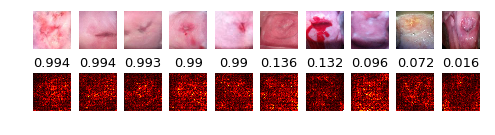

In [45]:
mask = np.arange(2 * num_images)
X, y, prob = type2_images, type2_labels, type2_probs
show_saliency_maps(X, y, mask, prob, 'best_model_googlenet_scaled7297', 
                   output_path = "../results/visualization/type2_saliency_scaled.png")

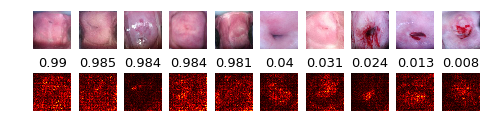

In [46]:
mask = np.arange(2 * num_images)
X, y, prob = type3_images, type3_labels, type3_probs
show_saliency_maps(X, y, mask, prob, 'best_model_googlenet_scaled7297', 
                   output_path = "../results/visualization/type3_saliency_scaled.png")

In [ ]:
np.save('googlenet_plots_ix', ix)

In [ ]:
print(len(ix))

In [57]:
np.savetxt('X_scaled_val_pred_prob.csv', X_val_pred_prob, delimiter=',')

In [58]:
np.savetxt('X_scaled_train_pred_prob.csv', X_train_pred_prob, delimiter=',')

In [ ]:
np.savetxt('X_val_pred_summary.csv', X_val_pred_summary, delimiter=',')
np.savetxt('X_train_pred_summary.csv', X_train_pred_summary, delimiter=',')
np.savetxt('X_val_pred_total.csv', X_val_pred_total, delimiter=',')
np.savetxt('X_train_pred_total.csv', X_train_pred_total, delimiter=',')